## Ejercicio 6

Re-implemente el ejercicio 5 utilizando las capas convolucionales del modelo Mobilenet V3 (clase **MobileNetV3Small** del paquete **tensorflow.keras.applications**) para extraer los patrones característicos y agregue una o más capas densas para entrenar una nueva red que permita reconocer los 16 tipos de flores del dataset **“Flowers”**. Recuerde que solo debe entrenar las capas densas.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from Fuentes.tf_util import EpochTiming
import tensorflow as tf

# Constantes para arquitectura, generación de datos y entrenamiento/validación
IMG_SIZE = (96, 96)  # Tamaño de la imagen de entrada (se elimina el canal de la tupla)
N_CLASSES = 16       # Cantidad de clases a identificar
LOTES = 256          # Tamaño de lotes para entrenamiento y testeo
ALFA = 0.00001       # Tasa de aprendizaje
EPOCAS = 100         # Cantidad de épocas a entrenar como máximo
PACIENCIA = 10       # Parámetro para parada temprana
VAL_SPLIT = 0.2      # Porcentaje para validación

DATOS_DIR = '../../Datos/'
IMAGES_DIR = DATOS_DIR + 'FlowersX16/'

# Función para crear datasets con aumento de datos
def create_dataset(directory, subset=None, shuffle=True):
    # Cargar dataset desde directorio
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=VAL_SPLIT,
        subset=subset,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=LOTES,
        shuffle=shuffle
    )

    # Normalización
    def preprocess(image, label):
        # Preprocesamiento específico para MobileNetV3
        image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
        return image, label

    # Aumento de datos (solo para entrenamiento)
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)

        # Zoom y desplazamiento
        if tf.random.uniform(()) > 0.5:
            image = tf.image.central_crop(image, 0.85)
            image = tf.image.resize(image, IMG_SIZE)

        return image, label

    dataset = dataset.map(preprocess)
    if subset == 'training':
        dataset = dataset.map(augment)

    return dataset.cache().prefetch(tf.data.AUTOTUNE)

# Crear datasets
train_iter = create_dataset(IMAGES_DIR, subset='training', shuffle=True)
valid_iter = create_dataset(IMAGES_DIR, subset='validation', shuffle=False)

Found 15740 files belonging to 16 classes.
Using 12592 files for training.


2025-10-21 09:30:39.758936: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Found 15740 files belonging to 16 classes.
Using 3148 files for validation.


#### Creación del modelo

In [3]:
from tensorflow.keras.applications import MobileNetV3Small
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras

# constantes para arquitectura, generación datos y entrenamiento/validacion
N_CLASSES = 16          # cantidad de clases a identificar
ALFA = 0.001            # tasa de entrenamiento
EPOCAS = 100            # cantidad de epocas a entrenar como máximo
PACIENCIA = 15          # parámetro para parada temprana

# obtiene la arquitectura para el modelo pre-entrenado
feature_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))

# congela capas iniciales, no las entrena, las usa para extraccione de caracteristicas
for layer in feature_model.layers:
    layer.trainable = False

# Construye el modelo con el método funcional
# GlobalAverage promedia la información de cada canal a 1 valor. Reduce significativamente la cantidad de parametros,
# ayuda a prevenir el sobreajuste y es invariante a la traslacion.
layers = GlobalAveragePooling2D() (feature_model.output)
layers = Dense(512)(layers)
layers = BatchNormalization()(layers)
layers = LeakyReLU()(layers)
layers = Dropout(0.5)(layers)
output = Dense(N_CLASSES, activation='softmax')(layers)

model = Model(inputs=feature_model.input, outputs=output)

#Optimizer
opt = Adam(learning_rate=ALFA)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/home/gblas/Developer/deep-learning-unlp/env/lib/python3.13/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 96, 96, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 48, 48,    │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 48, 48,    │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 49, 49,    │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 24, 24,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 24, 24,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 24, 24,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 24, 24,    │        256 │ expanded_conv_sq

 Total params: 1,244,800 (4.75 MB)

 Trainable params: 304,656 (1.16 MB)

 Non-trainable params: 940,144 (3.59 MB)

#### Entrenamiento

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 666ms/step - accuracy: 0.5735 - loss: 1.3951 - val_accuracy: 0.7881 - val_loss: 0.7014
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 517ms/step - accuracy: 0.7452 - loss: 0.7901 - val_accuracy: 0.8456 - val_loss: 0.5161
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.7794 - loss: 0.6742 - val_accuracy: 0.8507 - val_loss: 0.4680
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.8068 - loss: 0.5927 - val_accuracy: 0.8733 - val_loss: 0.4005
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.8236 - loss: 0.5399 - val_accuracy: 0.8675 - val_loss: 0.3990
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 276ms/step - accuracy: 0.8316 - loss: 0.4999 - val_accuracy: 0.8767 - val_loss: 0.3775
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.8436 - loss: 0.4674 - val_accuracy: 0.8799 - val_loss: 0.3663
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.8557 - loss: 0.4368 - 

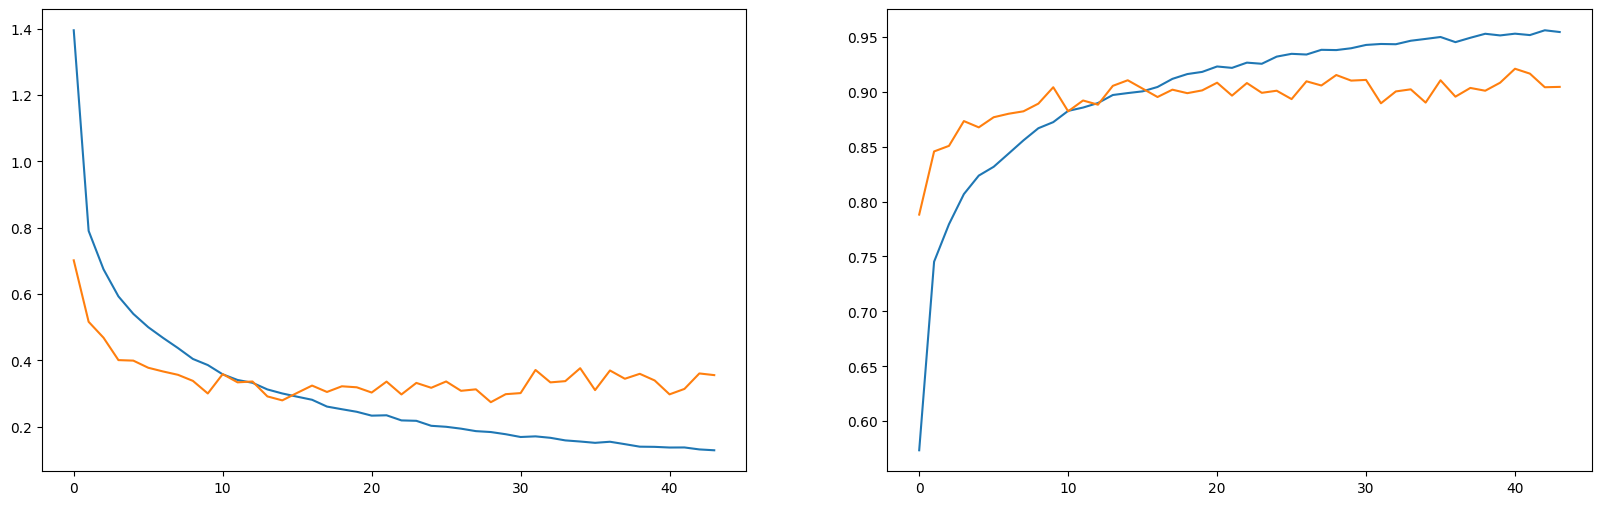

<Figure size 640x480 with 0 Axes>

In [4]:
# Callback para parada temprana
early_stop = EarlyStopping(monitor='val_loss',
                           patience=PACIENCIA,
                           restore_best_weights=True)

H = model.fit(
    train_iter,
    validation_data=valid_iter,
    epochs=EPOCAS,
    callbacks=[early_stop])

# dibuja accuracy del progreso del entrenamiento
fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")

In [ ]:
model.evaluate(train_iter)
model.evaluate(valid_iter)

50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - accuracy: 0.9718 - loss: 0.1070
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.9152 - loss: 0.2736


[0.27364903688430786, 0.9151842594146729]